# Environment Setup

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text processing
from sklearn.feature_extraction.text import TfidfVectorizer

# For model building and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Machine Learning models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb  # XGBoost library

# To handle sparse matrices
from scipy.sparse import hstack, csr_matrix

# For text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# For sentiment analysis
from textblob import TextBlob

# For progress bar
from tqdm import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data (if not already downloaded)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Load the data
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


[nltk_data] Downloading package stopwords to /Users/edaad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/edaad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/edaad/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Train shape: (1697533, 9)
Test shape: (212192, 2)


# Data Loading and Exploration

In [2]:
# Display first few rows of the training data
print(train_df.head())

# Check for missing values in training data
print("Missing values in training data:")
print(train_df.isnull().sum())


        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays with you   

                                                Text  S

# Feature Engineering

In [3]:
# Filter out rows with NaN 'Score' (these are the test samples)
train_non_null = train_df[train_df['Score'].notnull()].copy()

# Convert 'Score' to integer (if it's not already)
train_non_null['Score'] = train_non_null['Score'].astype(int)

# Set sample fraction (adjustable)
sample_fraction = 0.1  # Set to 0.1 for 10%, adjust as needed

# Sample a fraction of the non-null training data
train_sample = train_non_null.sample(frac=sample_fraction, random_state=42).copy()
train_sample.reset_index(drop=True, inplace=True)

print("Sampled train data shape:", train_sample.shape)

def add_features_to(df):
    # Handle missing values in 'HelpfulnessDenominator' to avoid division by zero
    df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].replace(0, np.nan)
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Convert 'Time' to datetime and extract components
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Review_Year'] = df['Time'].dt.year
    df['Review_Month'] = df['Time'].dt.month
    df['Review_Day'] = df['Time'].dt.day

    # Fill NaN in 'Summary' and 'Text'
    df['Summary'] = df['Summary'].fillna('')
    df['Text'] = df['Text'].fillna('')

    # Length of 'Summary' and 'Text'
    df['Summary_length'] = df['Summary'].str.len()
    df['Text_length'] = df['Text'].str.len()

    # Word count in 'Summary' and 'Text'
    df['Summary_word_count'] = df['Summary'].str.split().str.len()
    df['Text_word_count'] = df['Text'].str.split().str.len()
    
    return df

# Apply the function to the sampled train data
train_sample = add_features_to(train_sample)
train_sample.reset_index(drop=True, inplace=True)

# Prepare test data
test_ids = test_df['Id'].unique()
test_data = train_df[train_df['Id'].isin(test_ids)].copy()
test_data.reset_index(drop=True, inplace=True)

# Apply feature engineering to test data
test_data = add_features_to(test_data)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_lemmatize(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    # Tokenize
    words = text.split()
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join words back into one string
    return ' '.join(words)

# Combine 'Summary' and 'Text' in train and test data
train_sample['Combined_Text'] = train_sample['Summary'] + ' ' + train_sample['Text']
test_data['Combined_Text'] = test_data['Summary'] + ' ' + test_data['Text']

# Apply lemmatization to 'Combined_Text' with progress bar
print("Preprocessing training text data...")
train_sample['Cleaned_Text'] = [
    preprocess_text_lemmatize(text) for text in tqdm(train_sample['Combined_Text'])
]

print("Preprocessing test text data...")
test_data['Cleaned_Text'] = [
    preprocess_text_lemmatize(text) for text in tqdm(test_data['Combined_Text'])
]

def get_sentiment(text):
    analysis = TextBlob(text)
    return pd.Series([analysis.sentiment.polarity, analysis.sentiment.subjectivity])

# Apply to train data with progress bar
print("Performing sentiment analysis on training data...")
train_sentiment = pd.DataFrame([
    get_sentiment(text) for text in tqdm(train_sample['Cleaned_Text'])
], columns=['Polarity', 'Subjectivity'])

# Apply to test data with progress bar
print("Performing sentiment analysis on test data...")
test_sentiment = pd.DataFrame([
    get_sentiment(text) for text in tqdm(test_data['Cleaned_Text'])
], columns=['Polarity', 'Subjectivity'])

# Combine the data for vectorization
combined_cleaned_data = pd.concat([train_sample['Cleaned_Text'], test_data['Cleaned_Text']], axis=0)

# Initialize TF-IDF Vectorizer with increased max_features
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

print("Fitting TF-IDF vectorizer...")
# Fit and transform the combined text data
tfidf_combined_text = tfidf_vectorizer.fit_transform(combined_cleaned_data)

# Split the vectorized data back into train and test sets
tfidf_train = tfidf_combined_text[:len(train_sample)]
tfidf_test = tfidf_combined_text[len(train_sample):]

# Frequency encoding for 'ProductId' and 'UserId'
product_freq = train_sample['ProductId'].value_counts().to_dict()
user_freq = train_sample['UserId'].value_counts().to_dict()

train_sample['ProductFreq'] = train_sample['ProductId'].map(product_freq)
train_sample['UserFreq'] = train_sample['UserId'].map(user_freq)

test_data['ProductFreq'] = test_data['ProductId'].map(product_freq).fillna(0)
test_data['UserFreq'] = test_data['UserId'].map(user_freq).fillna(0)

# Add sentiment features to numeric features
train_sample['Polarity'] = train_sentiment['Polarity']
train_sample['Subjectivity'] = train_sentiment['Subjectivity']

test_data['Polarity'] = test_sentiment['Polarity']
test_data['Subjectivity'] = test_sentiment['Subjectivity']

# List of numerical features
numeric_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness',
                    'Summary_length', 'Text_length', 'Summary_word_count', 'Text_word_count',
                    'Review_Year', 'Review_Month', 'Review_Day',
                    'ProductFreq', 'UserFreq', 'Polarity', 'Subjectivity']

# Prepare numeric features for training and testing data
X_train_numeric = train_sample[numeric_features].fillna(0).reset_index(drop=True)
X_test_numeric = test_data[numeric_features].fillna(0).reset_index(drop=True)

# Combine TF-IDF features with numeric features
X_train_combined = hstack([tfidf_train, csr_matrix(X_train_numeric.values)])
X_test_combined = hstack([tfidf_test, csr_matrix(X_test_numeric.values)])

# Define the target variable
y_train = train_sample['Score']



Sampled train data shape: (148534, 9)
Preprocessing training text data...


100%|██████████| 148534/148534 [00:40<00:00, 3650.07it/s]


Preprocessing test text data...


100%|██████████| 212192/212192 [00:54<00:00, 3890.55it/s]


Performing sentiment analysis on training data...


100%|██████████| 148534/148534 [00:49<00:00, 3013.26it/s]


Performing sentiment analysis on test data...


100%|██████████| 212192/212192 [01:10<00:00, 2998.51it/s]


Fitting TF-IDF vectorizer...


# Handling Class Imbalance

In [4]:
# Check class distribution
print("Class distribution in training data:")
print(y_train.value_counts(normalize=True))

# Use class weights in models
class_weights = 'balanced'


Class distribution in training data:
Score
5    0.535790
4    0.226029
3    0.118195
1    0.061144
2    0.058842
Name: proportion, dtype: float64


# Model Building and Evaluation


In [5]:
# Split the training data into training and validation sets
X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train_combined, y_train, test_size=0.25, random_state=42)

print(f"Training data size: {X_train_part.shape[0]}")
print(f"Validation data size: {X_valid.shape[0]}")

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_part, label=y_train_part)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Define XGBoost parameters
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 6,  # Classes from 1 to 5 (inclusive)
    'max_depth': 6,
    'learning_rate': 0.1,
    'eval_metric': 'merror',
    'seed': 42,
    'verbosity': 1,
}

# Train the XGBoost model
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dvalid, 'validation')],
    early_stopping_rounds=10,
    verbose_eval=False
)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(dvalid)
accuracy_xgb = accuracy_score(y_valid, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l2']
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(max_iter=500, class_weight=class_weights),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_part, y_train_part)

# Best parameters
print("Best parameters found for Logistic Regression: ", grid_search.best_params_)

# Best estimator
best_logreg = grid_search.best_estimator_

# Predict and evaluate
y_pred_logreg = best_logreg.predict(X_valid)
accuracy_logreg = accuracy_score(y_valid, y_pred_logreg)
print("Logistic Regression Accuracy:", accuracy_logreg)



Training data size: 111400
Validation data size: 37134
XGBoost Accuracy: 0.6244950719017612


/Users/edaad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/edaad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/edaad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/edaad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/edaad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/edaad/anaconda3/lib/python3.11/site-packages/sklearn/linea

Best parameters found for Logistic Regression:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.6048096084450908


# Error Analysis


Classification Report for XGBoost:
              precision    recall  f1-score   support

           1       0.64      0.55      0.59      2373
           2       0.49      0.14      0.21      2166
           3       0.51      0.20      0.29      4382
           4       0.47      0.24      0.32      8401
           5       0.66      0.94      0.77     19812

    accuracy                           0.62     37134
   macro avg       0.55      0.42      0.44     37134
weighted avg       0.59      0.62      0.57     37134



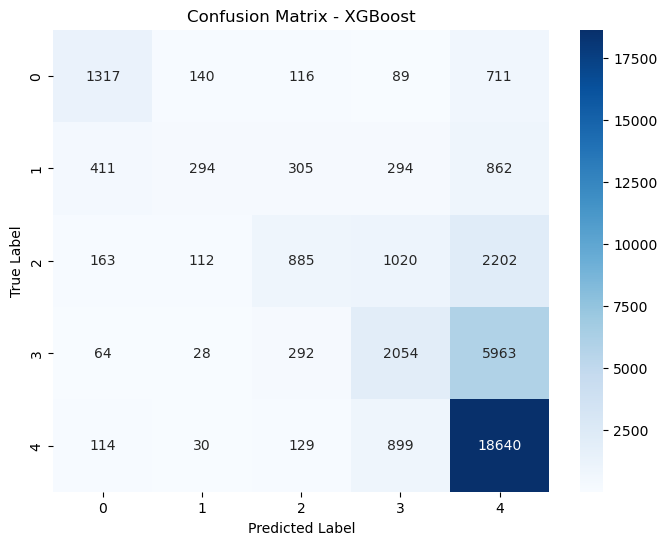

In [6]:
from sklearn.metrics import classification_report

print("Classification Report for XGBoost:")
print(classification_report(y_valid, y_pred_xgb))

# Confusion Matrix
conf_matrix = confusion_matrix(y_valid, y_pred_xgb)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Cross-Validation

In [7]:
# Cross-validation on the sampled training data
dtrain_full = xgb.DMatrix(X_train_combined, label=y_train)

print("Performing cross-validation with XGBoost...")
# Use cross-validation in XGBoost with verbose output
cv_results = xgb.cv(
    params=xgb_params,
    dtrain=dtrain_full,
    num_boost_round=100,
    nfold=3,
    metrics={'merror'},
    early_stopping_rounds=10,
    seed=42,
    verbose_eval=10  # Print progress every 10 iterations
)

print("XGBoost Cross-validation results:")
print(cv_results.tail(1))


Performing cross-validation with XGBoost...
[0]	train-merror:0.41357+0.00081	test-merror:0.42299+0.00161
[10]	train-merror:0.39958+0.00062	test-merror:0.41486+0.00162
[20]	train-merror:0.38857+0.00047	test-merror:0.40990+0.00137
[30]	train-merror:0.37677+0.00100	test-merror:0.40328+0.00154
[40]	train-merror:0.36506+0.00141	test-merror:0.39726+0.00163
[50]	train-merror:0.35337+0.00154	test-merror:0.39227+0.00122
[60]	train-merror:0.34287+0.00166	test-merror:0.38704+0.00099
[70]	train-merror:0.33363+0.00170	test-merror:0.38336+0.00060
[80]	train-merror:0.32582+0.00158	test-merror:0.37980+0.00073
[90]	train-merror:0.31834+0.00126	test-merror:0.37692+0.00040
[99]	train-merror:0.31251+0.00112	test-merror:0.37512+0.00056
XGBoost Cross-validation results:
    train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
99           0.312508          0.001122          0.375119         0.000562


# Final Model Training and Prediction

In [8]:
# Retrain the XGBoost model on the entire sampled training data
dtrain_full = xgb.DMatrix(X_train_combined, label=y_train)
dtest = xgb.DMatrix(X_test_combined)

print("Retraining XGBoost model on full training data...")
# Train the model
xgb_model_full = xgb.train(
    params=xgb_params,
    dtrain=dtrain_full,
    num_boost_round=len(cv_results),
    verbose_eval=False  # Suppress output during final training
)

print("Predicting on test data...")
# Predict on test data
y_test_pred = xgb_model_full.predict(dtest)

# Prepare submission file
submission = test_df[['Id']].copy()
submission['Score'] = y_test_pred.astype(int)  # Ensure integer scores

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


Retraining XGBoost model on full training data...
Predicting on test data...
Submission file created successfully!
